Here I explore the projection matrices available in the Kitti dataset related to odometry. I use functions from the Spatial Math Toolbox from Peter Corke as much as possible to try to focus on abstract concepts. The Spatial Math Toolbox code is easy to understand and can be explored at will.

In [46]:
import cv2
import pykitti
from spatialmath.base import e2h, h2e, r2t, rt2tr
import numpy as np

In [47]:
odom = pykitti.odometry(r"F:\DATASETS\KITTI\dataset", "04")

There are two color and two gray cameras. The gray ones are camera 0 and 1, separated by around 0.54 m:

In [48]:
cam0 = odom.cam0
cam1 = odom.cam1

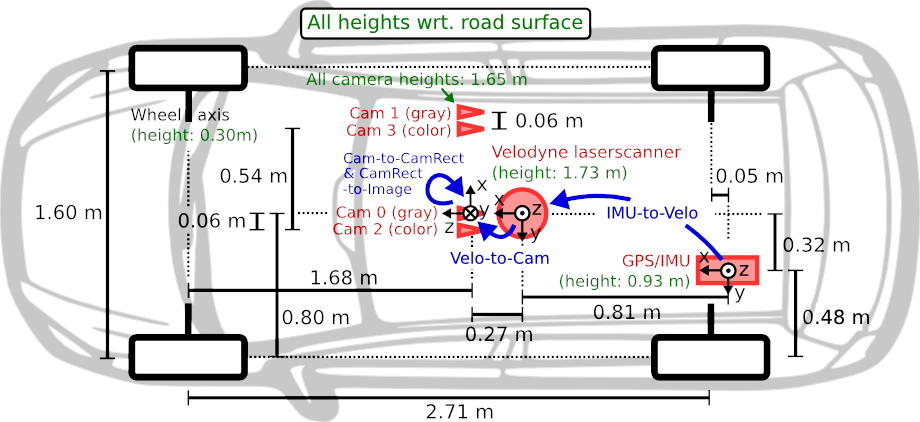

## The Projection Matrix or Camera Matrix

    Is a 3x4 homogeneous transformation which performs scaling, translation and perspective projection. (...) It can be factored into a 3x3 camera intrinsic matrix K, and a 3x4 camera extrinsic matrix. [1, p. 547]

Each camera used in the Kitti dataset has a projection matrix, but these are not standard projection matrices, which would re-express a 3D point P from the world coordinate frame to the i-th camera's frame.

A common projection matrix is the combination of:
  - The extrinsic matrix [R|t], which converts from world coordinates into camera coordinates.
  - The intrinsic matrix K, which converts points expressed in camera coordinates into the pixel coordinates.

    P = K[R|t]

Instead, each camera has a projection matrix that allows to project 3D points expressed in the coordinate frame of the i-th camera, into the frame of reference of camera 0.

[1] Peter Cork - Robotics, Vision and Control - Fundamental Algorithms in Python

In [49]:
P0 = odom.calib.P_rect_00
P1 = odom.calib.P_rect_10

In [50]:
P0.round(3), P1.round(3)

(array([[707.091,   0.   , 601.887,   0.   ],
        [  0.   , 707.091, 183.11 ,   0.   ],
        [  0.   ,   0.   ,   1.   ,   0.   ]]),
 array([[ 707.091,    0.   ,  601.887, -379.814],
        [   0.   ,  707.091,  183.11 ,    0.   ],
        [   0.   ,    0.   ,    1.   ,    0.   ]]))

A projection matrix can be decomposed into an intrinsic matrix `K`, a rotation matrix `R` and a translation vector `t`:

In [51]:
K0, R0, t0, _, _, _, _ = cv2.decomposeProjectionMatrix(P0)
K1, R1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)

In this case, the rotation matrices are just identities, so rotation is ocurring:

In [52]:
R0, R1

(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]))

There is some amount of translation occurrying in the x axis:

In [53]:
t0, t1.round(2)

(array([[0.],
        [0.],
        [0.],
        [1.]]),
 array([[ 0.47],
        [-0.  ],
        [ 0.  ],
        [ 0.88]]))

Notice how the translation vectors are in homogeneous coordinates, they can be transformed to euclidean coordinates using `h2e`, a function from the Spatial Math toolbox:

In [58]:
h2e(t1).round(3)

array([[ 0.537],
       [-0.   ],
       [ 0.   ]])

In [59]:
# rt2tr, from the Spatial Math toolbox, takes a rotation matrix in SO3 and a euclidean translation vector and 
# outputs a SE transformation. i.e. it mixes R and t into a homogeneous transformation matrix.
T = rt2tr(R1, h2e(t1))
T.round(3)

array([[ 1.   ,  0.   ,  0.   ,  0.537],
       [ 0.   ,  1.   ,  0.   , -0.   ],
       [ 0.   ,  0.   ,  1.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])


Here, the point [0,0,0,1], expressed in camera 1's frame of reference, is re-expressed in camera 0's frame of reference:

(Note: Point expressed in homogeneous coordinates.)

In [55]:
(T@[0,0,0,1]).round(3)

array([ 0.537, -0.   ,  0.   ,  1.   ])

Notice how the behavior of the available projection matrices is different than the one of the common projection matrices.

The intrinsic matrix K distorts the points expressed in the camera frame of reference and re-expresses them in the pixel frame of reference.

In [56]:
K0, K1

(array([[707.0912,   0.    , 601.8873],
        [  0.    , 707.0912, 183.1104],
        [  0.    ,   0.    ,   1.    ]]),
 array([[707.0912,   0.    , 601.8873],
        [  0.    , 707.0912, 183.1104],
        [  0.    ,   0.    ,   1.    ]]))